Rekognition custom label training is a customized mechanism that allows customers to train Rekognition for business case specific datasets. 

This notebook is aimed at generating model training metrics for this custom label training to enrich the available metrics for the benefit of the data scientist community to be better informed of the model performance.

The metrics that are generated from this notebook are

Confusion Matrix
Heat map
Classification report
Micro / Macro / Weighted precision
Micro / Macro / Weighted recall
Micro / Macro / Weighted F1 score
Raw accuracy
Balanced accuracy
Hamming loss
Jaccard score
Matthew's correlation coefficient


In [63]:
## Import all the python libraries to be used 
import boto3
import botocore
import json
import os
from requests import request
import pandas as pd
from io import BytesIO
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score


Rekognition custom label training input and output datasets are stored in specific s3 buckets. In order to derive the model metrics, we need the below summary datasets to be accessed.
1. GroundTruthManifest
2. EvaluationResult

Please refer the README file to know how to get project arn and version name if you are not sure

In [64]:
client=boto3.client('rekognition')

##User input needed in this section
## Replace the project arn and version name here
project_arn =  'arn:aws:rekognition:region:acc-id:project'
version_name = 'version-name.timestamp'



Using the project arn and version, we can get the s3 path of the testing output and evaluation dataset as below

In [65]:
response=client.describe_project_versions(ProjectArn=project_arn, VersionNames=[version_name])

## Here we retrieve the dataset that is generated as the output from testing
for test_ds in response['ProjectVersionDescriptions'] :
   test_s3_path = test_ds['TestingDataResult']['Output']['Assets'][0]['GroundTruthManifest']['S3Object']
   test_ds_bucket = test_s3_path.get('Bucket')
   test_ds_key = test_s3_path.get('Name')

   print(test_ds_bucket)
   print(test_ds_key)


## Here we retrieve the evaluation dataset details
for eval_ds in response['ProjectVersionDescriptions'] :
   eval_s3_path = eval_ds['EvaluationResult']['Summary']['S3Object']
   eval_ds_bucket = eval_s3_path.get('Bucket')
   eval_ds_key = eval_s3_path.get('Name')

   print(eval_ds_bucket)
   print(eval_ds_key)

custom-labels-console-us-east-1-b1dfa52f6c
evaluation/arn:aws:rekognition:us-east-1:353545601340:project/custom-metrics-project-blog/1615837768963/TestingGroundTruth-custom-metrics-project-blog-custom-metrics-project-blog.2021-04-19T14.44.03.json
custom-labels-console-us-east-1-b1dfa52f6c
evaluation/arn:aws:rekognition:us-east-1:353545601340:project/custom-metrics-project-blog/1615837768963/EvaluationResultSummary-custom-metrics-project-blog-custom-metrics-project-blog.2021-04-19T14.44.03.json


['backyard', 'backyard', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'closet', 'closet', 'entry way', 'entry way', 'front yard', 'front yard', 'front yard', 'kitchen', 'kitchen', 'kitchen', 'kitchen', 'living space', 'living space', 'living space', 'living space', 'living space', 'living space', 'living space', 'patio', 'patio']
['backyard', 'backyard', 'bathroom', 'bedroom', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bathroom', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'living space', 'bedroom', 'closet', 'closet', 'entry way', 'entry way', 'front yard', 'front yard', 'front yard', 'kitchen', 'kitchen', 'kitchen', 'kitchen', 'living space', 'living space', 'living space', 'living space', 'living space', 'living space', 'living space', 'patio', 'patio']
Precision 
micro precision = 0.9459459459459459
macro precision = 0.97023809

<AxesSubplot:>

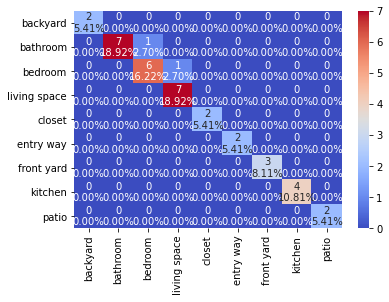

In [66]:
##read the evaluation dataset to get the list of labels defined as part of custom training
s3_client=boto3.client('s3')
eval_result = s3_client.get_object(Bucket=eval_ds_bucket, Key=eval_ds_key) 

eval_content = eval_result['Body'].read().decode('utf-8')
eval_dict = json.loads(eval_content)
label_list = eval_dict['EvaluationDetails']['Labels']

## read test summary dataset
test_result = s3_client.get_object(Bucket=test_ds_bucket, Key=test_ds_key) 

## For scikit learn libraries, we need a list of true classes and predicted classes. This is available in the test dataset
true_class = []
pred_class = []

for line in test_result["Body"].read().splitlines():
    
    json_dict = json.loads(line)
    
    for index in range(len(label_list)) :
        #Json record has keys that get appended with numbers to indicate that the evaluation is for a specific class. This number corresponds to the position of the class in the label list. However we need to standardize the keys for ease of querying 
        if ('rekognition-custom-labels-evaluation-' + str(index) in json_dict ) :
            true_class.append(json_dict['rekognition-custom-labels-training-0-metadata']['class-name']) 
            pred_class.append(json_dict['rekognition-custom-labels-evaluation-' + str(index) + '-metadata'] ['class-name'])

print(true_class)
print(pred_class)

#precision
    
micro_precision = precision_score(true_class, pred_class,labels=label_list,average='micro')
macro_precision = precision_score(true_class, pred_class,labels=label_list,average='macro')
weighted_precision = precision_score(true_class, pred_class,labels=label_list,average='weighted')

print("=========")
print("Precision ")
print("=========")
print
print("micro precision = " + str(micro_precision))
print("macro precision = " + str(macro_precision))
print("weighted precision = " + str(weighted_precision))

#recall

micro_recall = recall_score(true_class, pred_class, labels=label_list,average='micro')
macro_recall = recall_score(true_class, pred_class, labels=label_list,average='macro')
weighted_recall = recall_score(true_class, pred_class, labels=label_list,average='weighted')

print("=========")
print("Recall ")
print("=========")
print("micro recall = " + str(micro_recall))
print("macro recall = " + str(macro_recall))
print("weighted recall = " + str(weighted_recall))


# F1 score:

micro_f1 = f1_score(true_class, pred_class,labels=label_list,average='micro')
macro_f1 = f1_score(true_class, pred_class,labels=label_list,average='macro')
weighted_f1 = f1_score(true_class, pred_class,labels=label_list,average='weighted')

print("=========")
print("F1 score")
print("=========")
print("micro f1 = " + str(micro_f1))
print("macro f1 = " + str(macro_f1))
print("weighted f1 = " + str(weighted_f1))

## Raw accuracy

print("=========")
print("ACCURACY")
print("=========")

accuracy = accuracy_score(true_class,pred_class)
print("raw accuracy = " + str(accuracy))

balanced_accuracy = balanced_accuracy_score(true_class,pred_class)
print("balanced accuracy = " + str(balanced_accuracy))

##Hamming loss
hamming = hamming_loss(true_class,pred_class)

print("============")
print("Hamming loss")
print("============")
print(str(hamming))

##Jaccard score
print("==============")
print("Jaccard score")
print("==============")
jaccard_micro = jaccard_score(true_class, pred_class, average='micro')
print("Jaccard score micro average = " + str(jaccard_micro))

jaccard_macro = jaccard_score(true_class, pred_class, average='macro')
print("Jaccard score macro average = " + str(jaccard_macro))

jaccard_weighted = jaccard_score(true_class, pred_class, average='weighted')
print("Jaccard score weighted average = " + str(jaccard_weighted))

## Matthews Correlation coefficient
print("================================")
print("Matthews Correlation coefficient")
print("================================")
matthews_corr = matthews_corrcoef(true_class, pred_class)
print(matthews_corr)

##Classification report
target = label_list
print("=====================")
print("Classification Report")
print("=====================")
print(classification_report(true_class, pred_class, target_names=target))

##Confusion matrix

cf_matrix = confusion_matrix(true_class, pred_class,labels=label_list)

print("================")
print("Confusion matrix ")
print("================")
print(cf_matrix)

##Heat map

counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{val1}\n{val2}" for val1, val2 in
         zip(counts,percentages)]
         
labels = np.asarray(labels).reshape(len(label_list),len(label_list))


print("========")
print("Heat map")
print("========")

sn.heatmap(cf_matrix, annot=labels, xticklabels=label_list, yticklabels=label_list,fmt='', cmap='coolwarm')


